# Exercise 3

## Imports

In [2]:
# !pip install scikit-learn

In [3]:
import time
import os
import transformers
import optuna
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, balanced_accuracy_score
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

C:\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Data loading

In [4]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [5]:
ag_news_train_df.shape

(120000, 3)

In [6]:
ag_news_test_df.shape

(7600, 3)

In [7]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [8]:
amazon_reviews_df.shape

(17340, 4)

In [9]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [10]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

<Axes: >

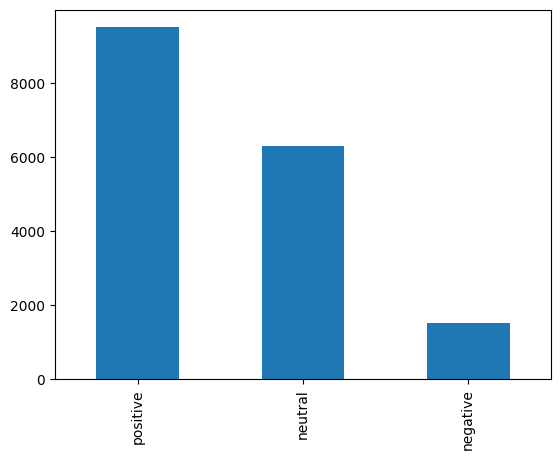

In [11]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

<Axes: >

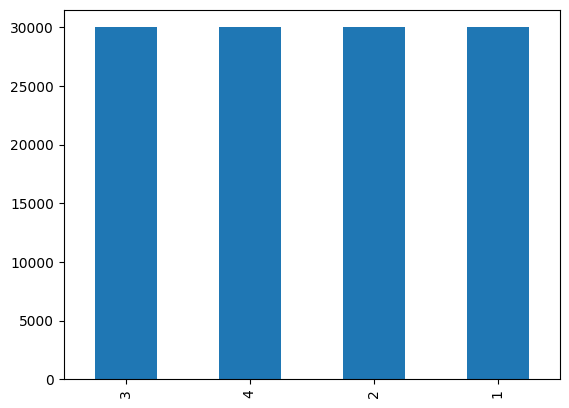

In [12]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <BarContainer object of 10 artists>)

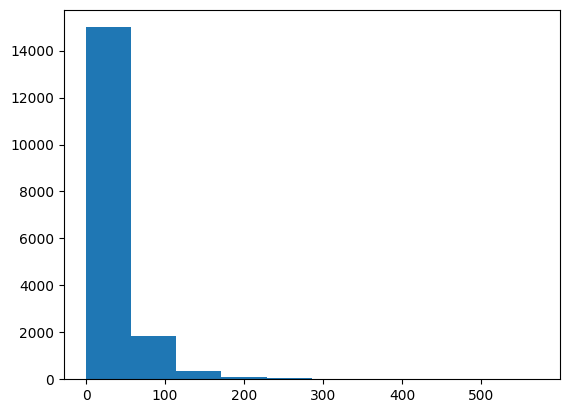

In [13]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

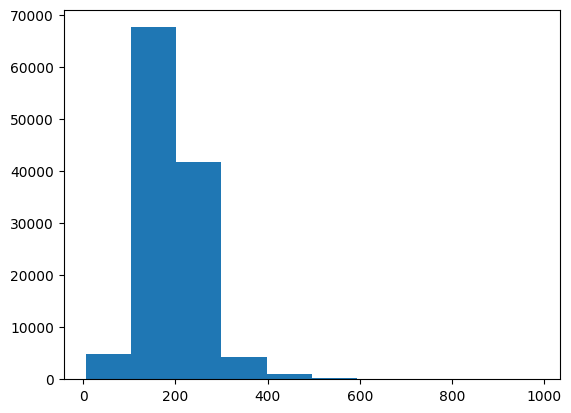

In [14]:
plt.hist(ag_news_train_df.Description.str.len())

In [15]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [16]:
amazon_reviews_df.dropna(inplace=True)

### Splitting amazon reviews into train and test set

In [17]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [18]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [19]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.33)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [20]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [21]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [22]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [23]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.33)

## Naive feature extraction

### Uni-Bigram vectorizer

Because documents are quite short on average, we used the uni-bigram vectorizer (contains both unigrams and bigrams)

Following pieces of code were taken from Sklearn's text feature extraction tutorial. (https://scikit-learn.org/stable/modules/feature_extraction.html)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
bigram_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1)

In [26]:
X_train_reviews_tr = bigram_vectorizer.fit_transform(X_train_reviews.cleaned_review)
X_valid_reviews_tr = bigram_vectorizer.transform(X_valid_reviews.cleaned_review)
X_test_reviews_tr = bigram_vectorizer.transform(X_test_reviews.cleaned_review)

In [27]:
bigram_vectorizer.get_feature_names_out()

array(['a', 'a bit', 'a bunch', ..., 'zoom while', 'zooms', 'zooms down'],
      dtype=object)

In [ ]:
X_train_news_tr = bigram_vectorizer.fit_transform(X_train_news)
X_valid_news_tr = bigram_vectorizer.transform(X_valid_news)
X_test_news_tr = bigram_vectorizer.transform(X_test_news)

In [43]:
from sklearn.decomposition import PCA, TruncatedSVD

In [59]:
pca = TruncatedSVD(n_components=100, n_iter=3, random_state=42)
pca.fit(X_train_news_tr)

TruncatedSVD(n_components=100, n_iter=3, random_state=42)

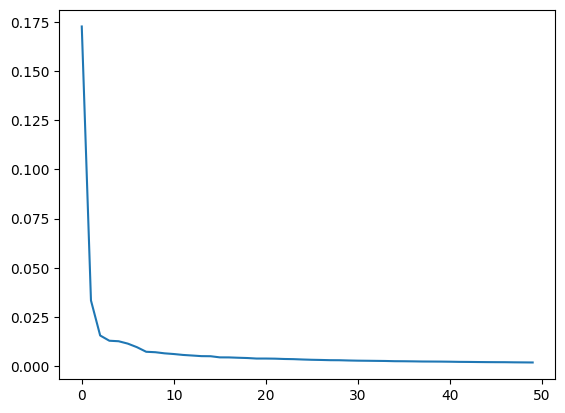

In [48]:
plt.plot(pca.explained_variance_ratio_)

In [56]:
np.sum(pca.explained_variance_ratio_)

0.7928252737952203

## Training shallow models

Balanced accuracy score is used to macro average across classes.

For hyperparam tuning only a half of training data will be used for performance reasons.

In [ ]:
np.random.seed(42)
reviews_train_idx = np.random.choice(y_train_reviews.shape[0], 
                                     replace=False, size=y_train_reviews.shape[0]//2)
news_train_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//8)

In [ ]:
X_train_reviews_half = X_train_reviews_tr[reviews_train_idx,:]
y_train_reviews_half = y_train_reviews.iloc[reviews_train_idx]

X_train_news_16th = X_train_news_tr[news_train_idx,:]
y_train_news_16th = y_train_news.iloc[news_train_idx]

X_train_news_8th = X_train_news_tr[news_train_idx,:]
y_train_news_8th = y_train_news.iloc[news_train_idx]

#### Checking if models are saved

In [ ]:
best_model_nn_reviews_is_saved = os.path.exists('models/best_model_nn_reviews.sav')
best_model_nn_news_is_saved = os.path.exists('models/best_model_nn_news.sav')
best_model_svm_reviews_is_saved = os.path.exists('models/best_model_svm_reviews.sav')
best_model_svm_news_is_saved = os.path.exists('models/best_model_svm_news.sav')

train_time_nn_reviews = 1258.6950891017914
train_time_nn_news = 16355.122691392899
train_time_svm_reviews = 98.50997948646545
train_time_svm_news = 7091.315309524536

### Shallow NN (One layer perceptron)

#### Reviews dataset

In [ ]:
available_activations = ['relu', 'logistic', 'tanh']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_reviews_half, y_train_reviews_half)
    y_pred_probas = model.predict_proba(X_valid_reviews_tr)
    return log_loss(y_valid_reviews, y_pred_probas)


if not best_model_nn_reviews_is_saved:
    study_nn_reviews = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_nn_reviews.optimize(objective, n_trials=10,show_progress_bar=True,n_jobs=-1)

    study_nn_reviews.best_params

{'size_of_hidden_layer': 85,
 'alpha': 0.00045434026867030927,
 'activation': 'logistic',
 'solver': 'adam'}

In [32]:
if not best_model_nn_reviews_is_saved:
    best_model_nn_reviews = MLPClassifier(hidden_layer_sizes=(85,), 
                              alpha=0.00045434026867030927,
                              solver='adam',
                              activation='logistic',
                                random_state=42,
                               learning_rate='adaptive',
                               verbose=True,
                              max_iter=50,
                          )
    start=time.time()
    best_model_nn_reviews.fit(X_train_reviews_tr, y_train_reviews)
    end=time.time()

    print("It took ", end-start, "seconds")
    train_time_nn_reviews = end-start

Iteration 1, loss = 0.85204182
Iteration 2, loss = 0.60728027
Iteration 3, loss = 0.44798095
Iteration 4, loss = 0.32897192
Iteration 5, loss = 0.24530914
Iteration 6, loss = 0.18774814
Iteration 7, loss = 0.14743751
Iteration 8, loss = 0.11937067
Iteration 9, loss = 0.09848032
Iteration 10, loss = 0.08324523
Iteration 11, loss = 0.07132085
Iteration 12, loss = 0.06231173
Iteration 13, loss = 0.05506250
Iteration 14, loss = 0.04923954
Iteration 15, loss = 0.04447541
Iteration 16, loss = 0.04050258
Iteration 17, loss = 0.03721316
Iteration 18, loss = 0.03442405
Iteration 19, loss = 0.03195646
Iteration 20, loss = 0.02990044
Iteration 21, loss = 0.02806770
Iteration 22, loss = 0.02647645
Iteration 23, loss = 0.02505352
Iteration 24, loss = 0.02379337
Iteration 25, loss = 0.02267507
Iteration 26, loss = 0.02165680
Iteration 27, loss = 0.02073603
Iteration 28, loss = 0.01992415
Iteration 29, loss = 0.01915732
Iteration 30, loss = 0.01847397
Iteration 31, loss = 0.01781248
Iteration 32, los

C:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
if not best_model_nn_reviews_is_saved:
    pickle.dump(best_model_nn_reviews, open('models/best_model_nn_reviews.sav', 'wb'))
    best_model_nn_reviews_is_saved = True
else:
    best_model_nn_reviews=pickle.load(open('models/best_model_nn_reviews.sav', 'rb'))

In [ ]:
y_preds_nn_reviews = best_model_nn_reviews.predict(X_valid_reviews_tr)

balanced_acc_shallow_nn_reviews = balanced_accuracy_score(y_valid_reviews, y_preds_nn_reviews)

In [ ]:
balanced_acc_shallow_nn_reviews

Reviews:
Baseline of shallow NNs (balanced accuracy = average of recalls for each class): __0.758__

#### News dataset

In [ ]:
available_activations = ['relu', 'logistic', 'tanh']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_news_16th, y_train_news_16th)
    y_pred_probas = model.predict_proba(X_valid_news_tr)
    return log_loss(y_valid_news, y_pred_probas)

if not best_model_nn_news_is_saved:
    study_nn_news = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_nn_news.optimize(objective, n_trials=10,show_progress_bar=True,n_jobs=2)

    study_nn_news.best_params

best value: 0.3686714944409208 (log loss)
 
best params:
{'size_of_hidden_layer': 34,
 'alpha': 0.0004980605929484772,
 'activation': 'tanh',
 'solver': 'adam'}
 
last:
{'size_of_hidden_layer': 28, 'alpha': 0.0009033187102132166, 'activation': 'tanh', 'solver': 'adam'}

In [37]:
if not best_model_nn_news_is_saved:
    start=time.time()
    best_model_nn_news = MLPClassifier(hidden_layer_sizes=(34,), 
                              alpha=0.0004980605929484772,
                              solver='adam',
                              activation='tanh',
                                random_state=42,
                               learning_rate='adaptive',
                               verbose=True,
                              max_iter=20,
                          )
    best_model_nn_news.fit(X_train_news_tr, y_train_news)
    end=time.time()

    print("It took ", end-start, "seconds")
    train_time_nn_news = end-start

Iteration 1, loss = 0.33724045
Iteration 2, loss = 0.05308799
Iteration 3, loss = 0.02711650
Iteration 4, loss = 0.01960663
Iteration 5, loss = 0.01510889
Iteration 6, loss = 0.01189128
Iteration 7, loss = 0.01017260
Iteration 8, loss = 0.00852699
Iteration 9, loss = 0.00773750
Iteration 10, loss = 0.00726638
Iteration 11, loss = 0.00785577
Iteration 12, loss = 0.01010342
Iteration 13, loss = 0.01611780
Iteration 14, loss = 0.02124843
Iteration 15, loss = 0.01925159
Iteration 16, loss = 0.01444418
Iteration 17, loss = 0.01230017
Iteration 18, loss = 0.01225840
Iteration 19, loss = 0.01196926
Iteration 20, loss = 0.01176749
It took  16355.122691392899 seconds


C:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [38]:
if not best_model_nn_news_is_saved:
    pickle.dump(best_model_nn_news, open('models/best_model_nn_news.sav', 'wb'))
    best_model_nn_news_is_saved = True
else:
    best_model_nn_news=pickle.load(open('models/best_model_nn_news.sav', 'rb'))

In [43]:
y_preds_nn_news = best_model_nn_news.predict(X_valid_news_tr)

balanced_acc_shallow_nn_news = balanced_accuracy_score(y_valid_news, y_preds_nn_news)

In [44]:
balanced_acc_shallow_nn_news

0.8971229026985744

News Baseline of shallow NNs (balanced accuracy = average of recalls for each class): __0.92__

### SVM

#### Reviews dataset

In [52]:
model_reviews = SVC(probability=True, random_state=42)
param_grid_reviews = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel':['poly', 'sigmoid', 'linear', 'rbf']} 
  
randomized_search_reviews = RandomizedSearchCV(model_reviews, param_grid_reviews, refit = True, verbose = 3, random_state=42)

In [ ]:
randomized_search_reviews.fit(X_train_reviews_half, y_train_reviews_half)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.731 total time=  33.4s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.689 total time=  31.4s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.742 total time=  31.7s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.736 total time=  29.9s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.705 total time=  30.3s
[CV 1/5] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.447 total time=  13.6s
[CV 2/5] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.492 total time=  13.3s
[CV 3/5] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.517 total time=  13.5s
[CV 4/5] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.466 total time=  13.4s
[CV 5/5] END ..C=0.1, gamma=0.1, kernel=sigmoid;, score=0.497 total time=  13.1s
[CV 1/5] END ....C=1, gamma=0.0001, kernel=poly;, score=0.540 total time=  17.6s
[CV 2/5] END ....C=1, gamma=0.0001, kernel=poly;

RandomizedSearchCV(estimator=SVC(probability=True, random_state=42),
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['poly', 'sigmoid', 'linear',
                                                   'rbf']},
                   random_state=42, verbose=3)

In [ ]:
randomized_search_reviews.best_params_

{'kernel': 'linear', 'gamma': 0.001, 'C': 10}

In [ ]:
randomized_search_reviews.best_score_

0.8103755917450837

In [34]:
if not best_model_svm_reviews_is_saved:
    start=time.time()
    best_model_svm_reviews =  SVC(probability=True, random_state=42, kernel='linear', gamma=0.001, C=10)
    best_model_svm_reviews.fit(X_train_reviews_tr, y_train_reviews)
    end=time.time()

    print("It took ", end-start, "seconds")
    train_time_svm_reviews = end-start

It took  98.50997948646545 seconds


In [58]:
if not best_model_svm_reviews_is_saved:
    pickle.dump(best_model_svm_reviews, open('models/best_model_svm_reviews.sav', 'wb'))
    best_model_svm_reviews_is_saved = True
else:
    best_model_svm_reviews=pickle.load(open('models/best_model_svm_reviews.sav', 'rb'))

In [59]:
y_preds_svm_reviews = best_model_svm_reviews.predict(X_valid_reviews_tr)

balanced_acc_svm_reviews = balanced_accuracy_score(y_valid_reviews, y_preds_svm_reviews)

In [60]:
balanced_acc_svm_reviews

0.7774100664712412

Balanced accuracy for reviews dataset with SVM: __0.78__

#### News dataset

In [ ]:
model = SVC(probability=True, random_state=42)
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel':['poly', 'sigmoid', 'linear', 'rbf']} 
  
randomized = RandomizedSearchCV(model, param_grid, refit = True, verbose = 3, random_state=42)

In [ ]:
randomized.fit(X_train_news_16th, y_train_news_16th)

In [ ]:
randomized.best_params_

In [ ]:
randomized.best_score_

In [36]:

if not best_model_svm_news_is_saved:
    start=time.time()
    best_model_svm_news = SVC(kernel='linear', gamma=0.001, C=10, verbose=True, random_state=42)
    best_model_svm_news.fit(X_train_news_tr, y_train_news)
    end=time.time()

    print("It took ", end-start, "seconds")
    train_time_svm_news = end-start

[LibSVM]It took  7091.315309524536 seconds


In [ ]:
if not best_model_svm_news_is_saved:
    pickle.dump(best_model_svm_news, open('models/best_model_svm_news.sav', 'wb'))
    print('dumped')
    best_model_nn_news_is_saved = True
# else:
#    best_model_svm_news=pickle.load(open('models/best_model_svm_news.sav', 'rb'))

In [82]:
y_preds_svm_news = best_model_svm_news.predict(X_valid_news_tr)

balanced_acc_svm_news = balanced_accuracy_score(y_valid_news, y_preds_svm_news)

In [83]:
balanced_acc_svm_news

0.7806725304721253

Balanced accuracy for news dataset with SVM: __0.912__

## Evaluating shallow models

## Tranining RNN architectures

### Architecture 2 - LSTM

## Evaluating RNN performance

## Comparison: RNNs vs Shallow